# Run All UDA Experiments (ME-IIS + Fair Baselines)

This notebook runs **source-only**, **ME-IIS**, and fair UDA baselines (**DANN**, **CORAL**, optional **pseudo-label self-training**) with:
- deterministic `run_id` + run directories under `outputs/runs/...`
- **skip/resume** (no redundant retraining)
- unified evaluation + `metrics.csv` per run
- QUICK mode (seed=[0]) and FULL mode (seed list)


## 1) Setup (clone + install)


In [13]:
import os, sys, subprocess
from pathlib import Path

IN_COLAB = "google.colab" in sys.modules
REPO_URL = os.getenv("REPO_URL", "https://github.com/kaminglui/ME-IIS.git")
REPO_DIR = Path(os.getenv("REPO_DIR", "/content/ME-IIS" if IN_COLAB else Path.cwd())).expanduser()
PULL_LATEST = True

if IN_COLAB:
    try:
        from google.colab import drive  # type: ignore
        if os.getenv("MOUNT_DRIVE", "0") == "1":
            drive.mount("/content/drive")
    except Exception as exc:
        print("[Drive] Skipping Drive mount:", exc)

if not REPO_DIR.exists():
    REPO_DIR.parent.mkdir(parents=True, exist_ok=True)
    subprocess.run(["git", "clone", REPO_URL, str(REPO_DIR)], check=True)
else:
    print(f"[Repo] Using existing repo at {REPO_DIR}")
    if PULL_LATEST:
        try:
            subprocess.run(["git", "pull", "--ff-only"], cwd=REPO_DIR, check=True)
        except subprocess.CalledProcessError as exc:
            print("[Repo][WARN] git pull failed (keeping existing checkout):", exc)

os.chdir(REPO_DIR)
print("[Repo] CWD:", Path.cwd())
try:
    sha = subprocess.check_output(["git", "rev-parse", "HEAD"]).decode().strip()
    print("[Repo] HEAD:", sha)
except Exception as exc:
    print("[Repo][WARN] Could not read git sha:", exc)


[Repo] Using existing repo at /content/ME-IIS
[Repo] CWD: /content/ME-IIS
[Repo] HEAD: 057fb70446f4eb365f5e8e814e4b0f3714d1c939


In [14]:
import sys, subprocess

subprocess.run([sys.executable, "-m", "pip", "install", "-r", "requirements.txt"], check=True)


CompletedProcess(args=['/usr/bin/python3', '-m', 'pip', 'install', '-r', 'requirements.txt'], returncode=0)

## 2) Config (single cell)


In [15]:
import os
from pathlib import Path

# Dataset (single place to edit)
DATASET_NAME = "office_home"  # office_home | office31
DATA_ROOT = ""  # optional path; leave blank to auto-download

# Optional: override via env vars (Colab-friendly)
DATASET_NAME = os.getenv("DATASET_NAME", DATASET_NAME)
DATA_ROOT = os.getenv("DATA_ROOT", DATA_ROOT)

# Mode
MODE = "FULL"  # QUICK | FULL
FORCE_RERUN = False

# Task
SOURCE_DOMAIN = "Ar"  # Office-Home: Ar/Cl/Pr/Rw ; Office-31: A/D/W
TARGET_DOMAIN = "Cl"

# Seeds
SEEDS = [0] if MODE == "QUICK" else [0, 1, 2]
DETERMINISTIC = True

# Training budget (fair across methods)
EPOCHS_SOURCE = 2 if MODE == "QUICK" else 50
EPOCHS_ADAPT = 2 if MODE == "QUICK" else 10
BATCH_SIZE = 16 if MODE == "QUICK" else 32
NUM_WORKERS = 2 if MODE == "QUICK" else 4

# Optimizer schedule
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-3
LR_BACKBONE = 1e-3
LR_CLASSIFIER = 1e-2

# Adaptation optimizer schedule (shared)
FINETUNE_BACKBONE = False
BACKBONE_LR_SCALE = 0.1
CLASSIFIER_LR_ADAPT = 1e-2

# Optional speed limits (keep 0 for real runs)
DRY_RUN_MAX_SAMPLES = 0
DRY_RUN_MAX_BATCHES = 0

# Where to store outputs. If you mounted Drive, you may want a Drive path here.
RUNS_ROOT = Path("outputs") / "runs"

# ME-IIS params
ME_IIS_PARAMS = {
    "feature_layers": ["layer3", "layer4"],
    "num_latent_styles": 5,
    "components_per_layer": None,
    "cluster_backend": "gmm",  # gmm | vmf_softmax
    "gmm_selection_mode": "bic",  # fixed | bic
    "gmm_bic_min_components": 2,
    "gmm_bic_max_components": 8,
    "vmf_kappa": 20.0,
    "cluster_clean_ratio": 1.0,
    "kmeans_n_init": 10,
    "source_prob_mode": "softmax",  # softmax | onehot
    "iis_iters": 5 if MODE == "QUICK" else 15,
    "iis_tol": 1e-3,
    "use_pseudo_labels": False,
    "pseudo_conf_thresh": 0.9,
    "pseudo_max_ratio": 1.0,
    "pseudo_loss_weight": 1.0,
}

# DANN params
DANN_PARAMS = {
    "disc_hidden_dim": 1024,
    "disc_dropout": 0.0,
    "dann_lambda_schedule": "grl",  # grl | linear | constant
    "domain_loss_weight": 1.0,
}

# CORAL params
CORAL_PARAMS = {
    "feature_layers": ["layer3", "layer4"],
    "coral_weight": 1.0,
}

# Pseudo-label baseline params
PL_PARAMS = {
    "pseudo_conf_thresh": 0.9,
    "pseudo_max_ratio": 1.0,
    "pseudo_loss_weight": 1.0,
}

print("[CFG] MODE:", MODE)
print("[CFG] DATASET_NAME:", DATASET_NAME)
print("[CFG] DATA_ROOT:", DATA_ROOT)
print("[CFG] TASK:", f"{SOURCE_DOMAIN} -> {TARGET_DOMAIN}")
print("[CFG] SEEDS:", SEEDS)
print("[CFG] RUNS_ROOT:", RUNS_ROOT)


[CFG] MODE: FULL
[CFG] DATASET_NAME: office_home
[CFG] DATA_ROOT: 
[CFG] TASK: Ar -> Cl
[CFG] SEEDS: [0, 1, 2]
[CFG] RUNS_ROOT: outputs/runs


## 3) Data (download/verify)

Supports `office_home` and `office31`.
- Leave `DATA_ROOT` blank to auto-download (KaggleHub).
- If you already have the dataset (or in Drive), set `DATA_ROOT` in the config cell.


In [16]:
from pathlib import Path


def _find_office_home_root(base: Path) -> Path:
    real_candidates = ["RealWorld", "Real World", "Real_World", "Real"]
    candidates = [base] + [p for p in base.rglob("*") if p.is_dir()]
    for cand in candidates:
        if all((cand / sub).exists() for sub in ["Art", "Clipart", "Product"]) and any((cand / r).exists() for r in real_candidates):
            return cand
    return base


def _find_office31_root(base: Path) -> Path:
    candidates = [base] + [p for p in base.rglob("*") if p.is_dir()]
    for cand in candidates:
        names = {p.name.lower() for p in cand.iterdir() if p.is_dir()}
        if {"amazon", "dslr", "webcam"} <= names:
            return cand
    return base


def _download_via_kagglehub(dataset_name: str) -> Path:
    try:
        import kagglehub  # type: ignore
    except ImportError:
        import sys, subprocess

        subprocess.run([sys.executable, "-m", "pip", "install", "kagglehub"], check=True)
        import kagglehub  # type: ignore

    if dataset_name == "office_home":
        raw = Path(kagglehub.dataset_download("lhrrraname/officehome"))
        return _find_office_home_root(raw)
    if dataset_name == "office31":
        raw = Path(kagglehub.dataset_download("xixuhu/office31"))
        return _find_office31_root(raw)
    raise ValueError(f"Unknown DATASET_NAME={dataset_name}")


data_root_str = str(DATA_ROOT).strip()
data_root_path = Path(data_root_str).expanduser() if data_root_str else None

if data_root_path is None:
    print("[Data] DATA_ROOT not set; downloading via KaggleHub...")
    data_root_path = _download_via_kagglehub(DATASET_NAME)
else:
    # Be forgiving if the user points to a parent directory.
    if DATASET_NAME == "office_home":
        expected = ["Art", "Clipart", "Product"]
        if not all((data_root_path / sub).exists() for sub in expected):
            data_root_path = _find_office_home_root(data_root_path)
    elif DATASET_NAME == "office31":
        expected = ["amazon", "dslr", "webcam"]
        names = {p.name.lower() for p in data_root_path.iterdir() if p.is_dir()} if data_root_path.exists() else set()
        if not set(expected) <= names:
            data_root_path = _find_office31_root(data_root_path)

DATA_ROOT = Path(data_root_path).resolve()
print("[Data] DATASET_NAME:", DATASET_NAME)
print("[Data] DATA_ROOT:", DATA_ROOT)
print("[Data] Exists:", DATA_ROOT.exists())


[Data] DATA_ROOT not set; downloading via KaggleHub...
Using Colab cache for faster access to the 'officehome' dataset.
[Data] DATASET_NAME: office_home
[Data] DATA_ROOT: /kaggle/input/officehome/datasets/OfficeHomeDataset_10072016
[Data] Exists: True


## 4) Run source-only (skip/resume)


In [17]:
import inspect, traceback
from src.experiments.run_config import RunConfig, get_run_dir
from src.experiments.runner import run_one as _run_one

def run_one_nb(cfg: RunConfig, **kwargs):
    """Notebook-safe wrapper around run_one (handles older runner.py versions)."""
    try:
        if 'raise_on_error' in inspect.signature(_run_one).parameters:
            return _run_one(cfg, raise_on_error=False, **kwargs)
        return _run_one(cfg, **kwargs)
    except Exception as exc:
        run_dir = get_run_dir(cfg, runs_root=kwargs.get('runs_root'))
        try:
            (run_dir / 'logs').mkdir(parents=True, exist_ok=True)
            with (run_dir / 'logs' / 'stderr.txt').open('a', encoding='utf-8') as f:
                f.write('\\n' + traceback.format_exc() + '\\n')
        except Exception:
            pass
        return {
            'status': 'failed',
            'run_dir': str(run_dir),
            'checkpoint': None,
            'metrics_csv': None,
            'error': f"{type(exc).__name__}: {exc}",
        }

def make_cfg(method: str, seed: int, method_params: dict | None = None) -> RunConfig:
    return RunConfig(
        dataset_name=DATASET_NAME,
        data_root=str(DATA_ROOT),
        source_domain=SOURCE_DOMAIN,
        target_domain=TARGET_DOMAIN,
        method=method,
        epochs_source=EPOCHS_SOURCE,
        epochs_adapt=0 if method == "source_only" else EPOCHS_ADAPT,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        momentum=MOMENTUM,
        weight_decay=WEIGHT_DECAY,
        lr_backbone=LR_BACKBONE,
        lr_classifier=LR_CLASSIFIER,
        finetune_backbone=False if method == "source_only" else FINETUNE_BACKBONE,
        backbone_lr_scale=0.1 if method == "source_only" else BACKBONE_LR_SCALE,
        classifier_lr=1e-2 if method == "source_only" else CLASSIFIER_LR_ADAPT,
        seed=seed,
        deterministic=DETERMINISTIC,
        dry_run_max_samples=DRY_RUN_MAX_SAMPLES,
        dry_run_max_batches=DRY_RUN_MAX_BATCHES,
        method_params={} if method == "source_only" else (method_params or {}),
    )

# Fairness guard: approximate optimizer-step budgets (epochs × batches)
from src.experiments.budget import estimate_total_steps
import pandas as pd

budget_seed = SEEDS[0]
budget_rows = []
for method, params in [
    ("source_only", {}),
    ("me_iis", ME_IIS_PARAMS),
    ("dann", DANN_PARAMS),
    ("coral", CORAL_PARAMS),
    ("pseudo_label", PL_PARAMS),
]:
    cfg_b = make_cfg(method, budget_seed, method_params=params)
    budget_rows.append({"method": method, "seed": budget_seed, **estimate_total_steps(cfg_b)})
display(pd.DataFrame(budget_rows))

source_runs = []
for seed in SEEDS:
    cfg = make_cfg("source_only", seed)
    res = run_one_nb(cfg, force_rerun=FORCE_RERUN, runs_root=RUNS_ROOT)
    print(f"[source_only][seed={seed}] status={res['status']} src_acc={res.get('source_acc_eval')} tgt_acc={res.get('target_acc_eval')} run_dir={res['run_dir']} ckpt={res.get('checkpoint')} metrics={res.get('metrics_csv')} error={res.get('error')}")
    source_runs.append(res)


,method,seed,source_batches_per_epoch,target_batches_per_epoch,steps_source,steps_adapt,steps_total
0,source_only,0,76,137,3800,0,3800
1,me_iis,0,76,137,3800,760,4560
2,dann,0,76,137,3800,760,4560
3,coral,0,76,137,3800,760,4560
4,pseudo_label,0,76,137,3800,760,4560


[source_only][seed=0] status=failed src_acc=None tgt_acc=None run_dir=outputs/runs/office-home/Ar2Cl/source_only/ff5caabb7e ckpt=None metrics=None error=AcceleratorError: CUDA error: device-side assert triggered
Search for `cudaErrorAssert' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html for more information.
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

[source_only][seed=1] status=failed src_acc=None tgt_acc=None run_dir=outputs/runs/office-home/Ar2Cl/source_only/6392f7f5ef ckpt=None metrics=None error=AcceleratorError: CUDA error: device-side assert triggered
Search for `cudaErrorAssert' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html for more information.
CUDA kernel errors might be asynchronously reported at some other API call, so th

## 5) Run adaptation (ME-IIS)


In [18]:
me_iis_runs = []
for seed in SEEDS:
    cfg = make_cfg("me_iis", seed, method_params=ME_IIS_PARAMS)
    res = run_one_nb(cfg, force_rerun=FORCE_RERUN, runs_root=RUNS_ROOT)
    print(f"[me_iis][seed={seed}] status={res['status']} src_acc={res.get('source_acc_eval')} tgt_acc={res.get('target_acc_eval')} run_dir={res['run_dir']} ckpt={res.get('checkpoint')} metrics={res.get('metrics_csv')} error={res.get('error')}")
    me_iis_runs.append(res)


[me_iis][seed=0] status=failed src_acc=None tgt_acc=None run_dir=outputs/runs/office-home/Ar2Cl/me_iis/5cf9c2d2db ckpt=None metrics=None error=AcceleratorError: CUDA error: device-side assert triggered
Search for `cudaErrorAssert' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html for more information.
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

[me_iis][seed=1] status=failed src_acc=None tgt_acc=None run_dir=outputs/runs/office-home/Ar2Cl/me_iis/530482cf36 ckpt=None metrics=None error=AcceleratorError: CUDA error: device-side assert triggered
Search for `cudaErrorAssert' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html for more information.
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below m

## 6) Run baselines (DANN / CORAL / pseudo-label)


In [19]:
baseline_runs = []

for seed in SEEDS:
    cfg = make_cfg("dann", seed, method_params=DANN_PARAMS)
    res = run_one_nb(cfg, force_rerun=FORCE_RERUN, runs_root=RUNS_ROOT)
    print(f"[dann][seed={seed}] status={res['status']} src_acc={res.get('source_acc_eval')} tgt_acc={res.get('target_acc_eval')} run_dir={res['run_dir']} ckpt={res.get('checkpoint')} metrics={res.get('metrics_csv')} error={res.get('error')}")
    baseline_runs.append(res)

for seed in SEEDS:
    cfg = make_cfg("coral", seed, method_params=CORAL_PARAMS)
    res = run_one_nb(cfg, force_rerun=FORCE_RERUN, runs_root=RUNS_ROOT)
    print(f"[coral][seed={seed}] status={res['status']} src_acc={res.get('source_acc_eval')} tgt_acc={res.get('target_acc_eval')} run_dir={res['run_dir']} ckpt={res.get('checkpoint')} metrics={res.get('metrics_csv')} error={res.get('error')}")
    baseline_runs.append(res)

for seed in SEEDS:
    cfg = make_cfg("pseudo_label", seed, method_params=PL_PARAMS)
    res = run_one_nb(cfg, force_rerun=FORCE_RERUN, runs_root=RUNS_ROOT)
    print(f"[pseudo_label][seed={seed}] status={res['status']} src_acc={res.get('source_acc_eval')} tgt_acc={res.get('target_acc_eval')} run_dir={res['run_dir']} ckpt={res.get('checkpoint')} metrics={res.get('metrics_csv')} error={res.get('error')}")
    baseline_runs.append(res)

print("[Logs] Each run writes logs to: <run_dir>/logs/stdout.txt and <run_dir>/logs/stderr.txt")


[dann][seed=0] status=failed src_acc=None tgt_acc=None run_dir=outputs/runs/office-home/Ar2Cl/dann/41c3d58383 ckpt=None metrics=None error=AcceleratorError: CUDA error: device-side assert triggered
Search for `cudaErrorAssert' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html for more information.
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

[dann][seed=1] status=failed src_acc=None tgt_acc=None run_dir=outputs/runs/office-home/Ar2Cl/dann/1acc8cd63e ckpt=None metrics=None error=AcceleratorError: CUDA error: device-side assert triggered
Search for `cudaErrorAssert' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html for more information.
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be 

## 7) Summaries (tables + plots)


[Summary] Found 4 metrics.csv files under outputs/runs/office-home/Ar2Cl


,method,seed,source_acc,target_acc,run_id,timestamp
0,coral,0,80.428513,33.127148,ffc0b32a86,2025-12-15T05:54:07.348328+00:00
1,dann,0,80.428513,33.127148,ab83d40821,2025-12-15T05:52:51.833925+00:00
2,me_iis,0,76.967450,28.568156,d3b3fbdc39,2025-12-15T05:51:35.466234+00:00
3,source_only,0,78.038731,30.148912,f2fc29f097,2025-12-15T05:49:20.217618+00:00


Target accuracy by method x seed:


seed,0
method,
coral,33.127148
dann,33.127148
me_iis,28.568156
source_only,30.148912


Mean ± std (target_acc):


,method,mean,std,count
0,coral,33.127148,NaN,1
1,dann,33.127148,NaN,1
3,source_only,30.148912,NaN,1
2,me_iis,28.568156,NaN,1


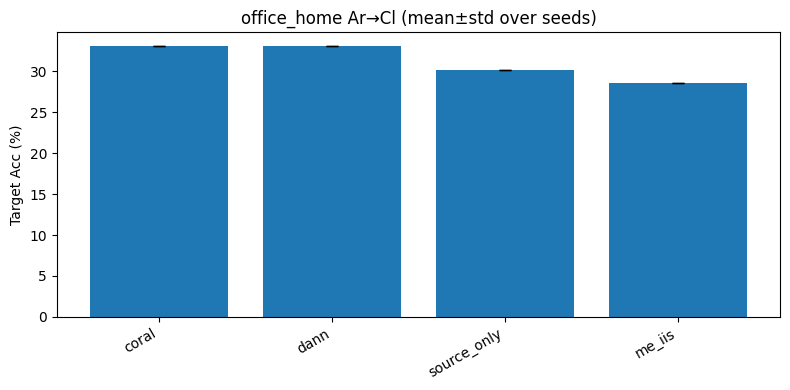

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

from src.experiments.notebook_summary import collect_expected_runs

expected_cfgs = []
for seed in SEEDS:
    expected_cfgs.append(make_cfg("source_only", seed))
    expected_cfgs.append(make_cfg("me_iis", seed, method_params=ME_IIS_PARAMS))
    expected_cfgs.append(make_cfg("dann", seed, method_params=DANN_PARAMS))
    expected_cfgs.append(make_cfg("coral", seed, method_params=CORAL_PARAMS))
    expected_cfgs.append(make_cfg("pseudo_label", seed, method_params=PL_PARAMS))

rows = collect_expected_runs(expected_cfgs, runs_root=RUNS_ROOT)
df = pd.DataFrame(rows)
df["target_acc_num"] = pd.to_numeric(df.get("target_acc"), errors="coerce")
df["target_display"] = df.apply(lambda r: r["target_acc_num"] if r["status"] == "OK" else r["status"], axis=1)

print(f"[Summary] Expected runs: {len(expected_cfgs)}")
display(df[["method", "seed", "status", "source_acc", "target_acc", "run_id", "metrics_csv"]])

pivot = df.pivot(index="method", columns="seed", values="target_display").fillna("NOT RUN")
print("Target accuracy by method x seed (or status):")
display(pivot)

ok = df[df["status"] == "OK"].copy()
if ok.empty:
    print("No successful runs yet.")
else:
    stats = ok.groupby("method")["target_acc_num"].agg(["mean", "std", "count"]).reset_index()
    stats = stats.sort_values("mean", ascending=False)
    stats["std"] = stats["std"].fillna(0.0)
    print("Mean ± std (target_acc over OK runs):")
    display(stats)

    plt.figure(figsize=(8, 4))
    plt.bar(stats["method"], stats["mean"], yerr=stats["std"], capsize=4)
    plt.ylabel("Target Acc (%)")
    plt.title(f"{DATASET_NAME} {SOURCE_DOMAIN}→{TARGET_DOMAIN} (mean±std over seeds)")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()


## 8) Export artifacts


In [21]:
import pandas as pd
from utils.experiment_utils import dataset_tag
from src.experiments.notebook_summary import collect_expected_runs

expected_cfgs = []
for seed in SEEDS:
    expected_cfgs.append(make_cfg("source_only", seed))
    expected_cfgs.append(make_cfg("me_iis", seed, method_params=ME_IIS_PARAMS))
    expected_cfgs.append(make_cfg("dann", seed, method_params=DANN_PARAMS))
    expected_cfgs.append(make_cfg("coral", seed, method_params=CORAL_PARAMS))
    expected_cfgs.append(make_cfg("pseudo_label", seed, method_params=PL_PARAMS))

rows = collect_expected_runs(expected_cfgs, runs_root=RUNS_ROOT)
df = pd.DataFrame(rows)

ds_tag = dataset_tag(DATASET_NAME)
pair = f"{SOURCE_DOMAIN}2{TARGET_DOMAIN}"
out_dir = RUNS_ROOT / ds_tag / pair
out_dir.mkdir(parents=True, exist_ok=True)

export_path = out_dir / "all_metrics.csv"
df.to_csv(export_path, index=False)
print("[Export] Wrote:", export_path)


[Export] Wrote: outputs/runs/office-home/Ar2Cl/all_metrics.csv
